In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-_rb_mbwi
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-_rb_mbwi
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-wtksrkl8/pyfolio_bb463ef6e2df44a9865569edec3f0fa9
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-wtksrkl8/pyfolio_bb463ef6e2df44a9865569edec3f0fa9


# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- ASSUMES USING DOCKER, see readme for instructions

<a id='1.1'></a>
## 2.1. Add FinRL to your path. You can of course install it as a pipy package, but this is for development purposes.


In [2]:
import sys

sys.path.append("..")

In [3]:
import pandas as pd
print(pd.__version__)

1.1.5



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts


import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [7]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [8]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [9]:
tickers = ['IBM', 'JNJ', 'CSCO']

df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (9063, 8)


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


In [11]:
processed['log_volume'] = np.log(processed.volume*processed.close)
processed['change'] = (processed.close-processed.open)/processed.close
processed['daily_variance'] = (processed.high-processed.low)/processed.close
processed = processed.sort_values(['date','tic'],ignore_index=True)

processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,log_volume,change,daily_variance
0,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.000000,100.0,66.666667,100.0,20.054798,-0.312196,0.059972
1,2009-01-02,83.889999,87.589996,83.889999,59.180256,7558200,IBM,4,0.000000,100.0,66.666667,100.0,19.918732,-0.417534,0.062521
2,2009-01-02,60.130001,61.000000,59.040001,41.743183,11638900,JNJ,4,0.000000,100.0,66.666667,100.0,20.001400,-0.440475,0.046954
3,2009-01-05,16.850000,17.299999,16.750000,12.616367,45480200,CSCO,0,0.002482,100.0,66.666667,100.0,20.167783,-0.335567,0.043594
4,2009-01-05,86.419998,87.669998,86.180000,58.807713,8315700,IBM,0,-0.008358,0.0,66.666667,100.0,20.007929,-0.469535,0.025337


In [12]:
processed.tail()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,log_volume,change,daily_variance
9058,2020-12-30,123.800003,124.849998,123.629997,121.344566,3380300,IBM,2,0.942977,53.526733,25.698264,8.631853,19.832109,-0.020235,0.010054
9059,2020-12-30,154.740005,156.380005,154.600006,154.121399,5412800,JNJ,2,1.989442,60.110872,138.167413,36.390216,20.542018,-0.004014,0.011549
9060,2020-12-31,44.380001,44.840000,44.160000,43.768875,15105500,CSCO,3,0.729098,60.122488,52.041086,26.466234,20.309492,-0.013963,0.015536
9061,2020-12-31,124.220001,126.029999,123.989998,122.847458,3574400,IBM,3,0.990787,55.298767,59.217370,15.707054,19.900251,-0.011173,0.016606
9062,2020-12-31,156.529999,157.660004,155.110001,155.434952,5099900,JNJ,3,2.197554,61.476412,147.739389,41.330979,20.490959,-0.007045,0.016406


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2016-01-01
## Trade data split: 2016-01-01 to 2021-01-01

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2016-01 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [13]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

7548
1515


## Create the stock trading environment

In [14]:

import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
from copy import deepcopy

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
import random

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
#from stable_baselines3.common import logger
import time

class MyStockTradingEnvCashpenalty(gym.Env):
    """
    A stock trading environment for OpenAI gym
    This environment penalizes the model for not maintaining a reserve of cash.
    This enables the model to manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) - initial_cash - max(0, sum(cash, asset_value)*cash_penalty_proportion-cash))/(days_elapsed)
        This reward function takes into account a liquidity requirement, as well as long-term accrued rewards.
    Parameters:
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int, array): maximum cash to be traded in each trade per asset. If an array is provided, then each index correspond to each asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares can be bought in each trade. Only applicable if discrete_actions=True
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. It could be OHLC columns or any other variables such as technical indicators and turbulence index
        cash_penalty_proportion (int, float): Penalty to apply if the algorithm runs out of cash
        patient (bool): option to choose whether end the cycle when we're running out of cash or just don't buy anything until we got additional cash
    RL Inputs and Outputs
        action space: [<n_assets>,] in range {-1, 1}
        state space: {start_cash, [shares_i for in in assets], [[indicator_j for j in indicators] for i in assets]]}
    TODO:
        Organize functions
        Write README
        Document tests
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        buy_cost_pct=3e-3,
        sell_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        discrete_actions=False,
        shares_increment=1,
        turbulence_threshold=None,
        print_verbosity=10,
        initial_amount=1e6,
        daily_information_cols=['open', 'high', 'low', 'close', 'volume'],
        cache_indicator_data=True,
        cash_penalty_proportion=0.1,
        random_start=True,
        patient=False,
        currency="$",
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start
        self.discrete_actions = discrete_actions
        self.patient = patient
        self.currency = currency
        self.df = self.df.set_index(date_col_name)
        self.shares_increment = shares_increment
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.turbulence_threshold = turbulence_threshold
        self.daily_information_cols = daily_information_cols
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.turbulence = 0
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [
                self.get_date_vector(i) for i, _ in enumerate(self.dates)
            ]
            print("data cached!")

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)

    @property
    def current_step(self):
        return self.date_index - self.starting_point

    @property
    def cash_on_hand(self):
        # amount of cash held at current timestep
        return self.state_memory[-1][0]

    @property
    def holdings(self):
        # Quantity of shares held at current timestep
        return self.state_memory[-1][1 : len(self.assets) + 1]

    @property
    def closings(self):
        return np.array(self.get_date_vector(self.date_index, cols=["close"]))

    def reset(self):
        self.seed()
        self.sum_trades = 0
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.turbulence = 0
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            "reward": [],
        }
        init_state = np.array(
            [self.initial_amount]
            + [0] * len(self.assets)
            + self.get_date_vector(self.date_index)
        )
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[[date]]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v

    def return_terminal(self, reason="Last Date", reward=0):
        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        # Add outputs to logger interface
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        # logger.record("environment/GainLoss_pct", (gl_pct - 1) * 100)
        # logger.record(
        #     "environment/total_assets",
        #     int(self.account_information["total_assets"][-1]),
        # )
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        # logger.record("environment/total_reward_pct", (reward_pct - 1) * 100)
        # logger.record("environment/total_trades", self.sum_trades)
        # logger.record(
        #     "environment/avg_daily_trades",
        #     self.sum_trades / (self.current_step),
        # )
        # logger.record(
        #     "environment/avg_daily_trades_per_asset",
        #     self.sum_trades / (self.current_step) / len(self.assets),
        # )
        # logger.record("environment/completed_steps", self.current_step)
        # logger.record(
        #     "environment/sum_rewards", np.sum(self.account_information["reward"])
        # )
        # logger.record(
        #     "environment/cash_proportion",
        #     self.account_information["cash"][-1]
        #     / self.account_information["total_assets"][-1],
        # )
        return state, reward, True, {}

    def log_step(self, reason, terminal_reward=None):

        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1]
        )
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        rec = [
            self.episode,
            self.date_index - self.starting_point,
            reason,
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['cash'][-1]))}",
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['total_assets'][-1]))}",
            f"{terminal_reward*100:0.5f}%",
            f"{(gl_pct - 1)*100:0.5f}%",
            f"{cash_pct*100:0.2f}%",
        ]
        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def log_header(self):
        if self.printed_header is False:
            self.template = "{0:4}|{1:4}|{2:15}|{3:15}|{4:15}|{5:10}|{6:10}|{7:10}"  # column widths: 8, 10, 15, 7, 10
            print(
                self.template.format(
                    "EPISODE",
                    "STEPS",
                    "TERMINAL_REASON",
                    "CASH",
                    "TOT_ASSETS",
                    "TERMINAL_REWARD_unsc",
                    "GAINLOSS_PCT",
                    "CASH_PROPORTION",
                )
            )
            self.printed_header = True

    def get_reward(self):
        if self.current_step == 0:
            return 0
        else:
            assets = self.account_information["total_assets"][-1]
            cash = self.account_information["cash"][-1]
            cash_penalty = max(0, (assets * self.cash_penalty_proportion - cash))
            assets -= cash_penalty
            reward = (assets / self.initial_amount) - 1
            reward /= self.current_step
            return reward

    def get_transactions(self, actions):
        """
        This function takes in a raw 'action' from the model and makes it into realistic transactions
        This function includes logic for discretizing
        It also includes turbulence logic.
        """
        # record actions of the model
        self.actions_memory.append(actions)

        # multiply actions by the hmax value
        actions = actions * self.hmax

        # Do nothing for shares with zero value
        actions = np.where(self.closings > 0, actions, 0)

        # discretize optionally
        if self.discrete_actions:
            # convert into integer because we can't buy fraction of shares
            actions = actions // self.closings
            actions = actions.astype(int)
            # round down actions to the nearest multiplies of shares_increment
            actions = np.where(
                actions >= 0,
                (actions // self.shares_increment) * self.shares_increment,
                ((actions + self.shares_increment) // self.shares_increment)
                * self.shares_increment,
            )
        else:
            actions = actions / self.closings

        # can't sell more than we have
        actions = np.maximum(actions, -np.array(self.holdings))

        # deal with turbulence
        if self.turbulence_threshold is not None:
            # if turbulence goes over threshold, just clear out all positions
            if self.turbulence >= self.turbulence_threshold:
                actions = -(np.array(self.holdings))
                self.log_step(reason="TURBULENCE")

        return actions

    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step.
        self.sum_trades += np.sum(np.abs(actions))
        self.log_header()
        # print if it's time.
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")
        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            """
            First, we need to compute values of holdings, save these, and log everything.
            Then we can reward our model for its earnings.
            """
            # compute value of cash + assets
            begin_cash = self.cash_on_hand
            assert min(self.holdings) >= 0
            asset_value = np.dot(self.holdings, self.closings)
            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)

            # compute reward once we've computed the value of things!
            reward = self.get_reward()
            self.account_information["reward"].append(reward)

            """
            Now, let's get down to business at hand. 
            """
            transactions = self.get_transactions(actions)

            # compute our proceeds from sells, and add to cash
            sells = -np.clip(transactions, -np.inf, 0)
            proceeds = np.dot(sells, self.closings)
            costs = proceeds * self.sell_cost_pct
            coh = begin_cash + proceeds
            # compute the cost of our buys
            buys = np.clip(transactions, 0, np.inf)
            spend = np.dot(buys, self.closings)
            costs += spend * self.buy_cost_pct
            # if we run out of cash...
            if (spend + costs) > coh:
                if self.patient:
                    # ... just don't buy anything until we got additional cash
                    self.log_step(reason="CASH SHORTAGE")
                    transactions = np.where(transactions > 0, 0, transactions)
                    spend = 0
                    costs = 0
                else:
                    # ... end the cycle and penalize
                    return self.return_terminal(
                        reason="CASH SHORTAGE", reward=self.get_reward()
                    )
            self.transaction_memory.append(
                transactions
            )  # capture what the model's could do
            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh
            # update our holdings
            coh = coh - spend - costs
            holdings_updated = self.holdings + transactions
            self.date_index += 1
            if self.turbulence_threshold is not None:
                self.turbulence = self.get_date_vector(
                    self.date_index, cols=["turbulence"]
                )[0]
            # Update State
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)

        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs

    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)

        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[
                -len(self.account_information["cash"]) :
            ]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame(
                {
                    "date": self.dates[-len(self.account_information["cash"]) :],
                    "actions": self.actions_memory,
                    "transactions": self.transaction_memory,
                }
            )

In [15]:
print(MyStockTradingEnvCashpenalty.__doc__)


    A stock trading environment for OpenAI gym
    This environment penalizes the model for not maintaining a reserve of cash.
    This enables the model to manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) - initial_cash - max(0, sum(cash, asset_value)*cash_penalty_proportion-cash))/(days_elapsed)
        This reward function takes into account a liquidity requirement, as well as long-term accrued rewards.
    Parameters:
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int, array): maximum cash to be traded in each trade per asset. If an array is provided, then each index correspond to each asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares ca

#### state space
The state space of the observation is as follows 

`start_cash, <owned_shares_of_n_assets>, <<indicator_i_for_asset_j> for j in assets>`

indicators are any daily measurement you can achieve. Common ones are 'volume', 'open' 'close' 'high', 'low'.
However, you can add these as needed, 
The feature engineer adds indicators, and you can add your own as well. 


In [16]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,log_volume,change,daily_variance
0,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.000000,100.0,66.666667,100.0,20.054798,-0.312196,0.059972
1,2009-01-02,83.889999,87.589996,83.889999,59.180256,7558200,IBM,4,0.000000,100.0,66.666667,100.0,19.918732,-0.417534,0.062521
2,2009-01-02,60.130001,61.000000,59.040001,41.743183,11638900,JNJ,4,0.000000,100.0,66.666667,100.0,20.001400,-0.440475,0.046954
3,2009-01-05,16.850000,17.299999,16.750000,12.616367,45480200,CSCO,0,0.002482,100.0,66.666667,100.0,20.167783,-0.335567,0.043594
4,2009-01-05,86.419998,87.669998,86.180000,58.807713,8315700,IBM,0,-0.008358,0.0,66.666667,100.0,20.007929,-0.469535,0.025337


In [17]:
information_cols = ['daily_variance', 'change', 'log_volume', 'close','day', 
                    'macd', 'rsi_30', 'cci_30', 'dx_30']

e_train_gym = MyStockTradingEnvCashpenalty(df = train,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.1,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = True)

e_trade_gym = MyStockTradingEnvCashpenalty(df = trade,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.1,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = False)

caching data
data cached!
caching data
data cached!


## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [18]:
# for this example, let's do multiprocessing with n_cores-2
import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 24
print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

using 24 cores


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)

### Model PPO


In [20]:
# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 1024, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024 for _ in range(10)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

# model = model.load("scaling_reward.model", env = env_train)

{'n_steps': 256, 'ent_coef': 0.0, 'learning_rate': 5e-06, 'batch_size': 1024, 'gamma': 0.99}


In [21]:
model.learn(total_timesteps = 20000, 
            eval_env = env_trade, 
            eval_freq = 500,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fb2d6f656d0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fb2d6f65b90>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$1,000,000     |$1,000,000     |0.00000%  |0.00000%  |100.00%   
   1| 504|Last Date      |$1,000,000     |$1,000,000     |0.00000%  |0.00000%  |100.00%   
Eval num_timesteps=12000, episode_reward=0.00 +/- 0.00
Episode length: 505.00 +/- 0.00
New best mean reward!
   3| 499|update         |$679,637       |$999,035       |-0.00019% |-0.09647% |68.03%    
   3| 504|Last Date      |$676,420       |$1,000,917     |0.00018%  |0.09165%  |67.58%    
Eval num_timesteps=24000, episode_reward=0.00 +/- 0.00
Episode length: 505.00 +/- 0.00
New best mean reward!


In [22]:
model.save("different1_24.model")

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [23]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,log_volume,change,daily_variance
0,2019-01-02,42.279999,43.200001,42.209999,39.496738,23833500,CSCO,2,-0.939011,44.872565,-87.556999,29.529377,20.662821,-0.070468,0.025065
0,2019-01-02,112.010002,115.980003,111.690002,101.942413,4239900,IBM,2,-2.264893,42.655674,-75.909284,19.746436,19.884458,-0.098758,0.042083
0,2019-01-02,128.130005,128.380005,126.279999,119.464256,7631700,JNJ,2,-3.988228,40.136256,-90.896149,41.067317,20.630838,-0.072538,0.017579
1,2019-01-03,42.299999,42.410000,40.959999,38.060322,29606700,CSCO,3,-1.016141,41.861397,-119.073431,37.886570,20.842684,-0.111394,0.038097
1,2019-01-03,114.529999,114.879997,112.690002,99.907280,4346700,IBM,3,-2.212195,40.845558,-83.308115,19.746436,19.889170,-0.146363,0.021920


In [24]:
e_trade_gym.hmax = 5000

In [25]:
print(len(e_trade_gym.dates))

505


In [26]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$569,720       |$1,002,208     |0.00044%  |0.22082%  |56.85%    
   1| 504|Last Date      |$572,993       |$1,004,444     |0.00088%  |0.44440%  |57.05%    
hit end!


In [27]:
df_actions.head()

,date,actions,transactions
0,2019-01-03,"[0.9945836, -0.8749739, -0.05623682]","[125.90705374521687, -0.0, -0.0]"
1,2019-01-04,"[0.7556748, -1.0, -0.045799278]","[99.27330090300117, -0.0, -0.0]"
2,2019-01-07,"[-1.0, 0.58669007, -0.028368175]","[-125.7078933416402, 28.258039774646058, -0.0]"
3,2019-01-08,"[-0.1722001, -1.0, -1.0]","[-21.501631774378637, -28.258039774646058, -0.0]"
4,2019-01-09,"[-1.0, 1.0, -0.32578418]","[-77.9708295321992, 47.156306216946206, -0.0]"


In [28]:
df_account_value.shape

(504, 5)

In [29]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2019-01-03
1,995012.163277,4792.062983,9.998042e+05,-0.000196,2019-01-04
2,991222.454377,8956.492256,1.000179e+06,0.000089,2019-01-07
3,993265.203586,6937.428756,1.000203e+06,0.000068,2019-01-08
4,997068.962193,3147.514849,1.000216e+06,0.000054,2019-01-09
5,995192.034497,5035.884585,1.000228e+06,0.000046,2019-01-10
6,985162.034497,15157.603736,1.000320e+06,0.000053,2019-01-11
7,988925.707673,11360.149523,1.000286e+06,0.000041,2019-01-14
8,985783.906259,14361.230449,1.000145e+06,0.000018,2019-01-15
9,983667.894633,16654.359297,1.000322e+06,0.000036,2019-01-16


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [30]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')

==============Get Backtest Results===========
Annual return          0.002220
Cumulative returns     0.004444
Annual volatility      0.079585
Sharpe ratio           0.067677
Calmar ratio           0.019899
Stability              0.136744
Max drawdown          -0.111540
Omega ratio            1.013944
Sortino ratio          0.094052
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023687
Daily value at risk   -0.010005
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-03
End date,2020-12-31
Total months,24
,Backtest
Annual return,0.222%
Cumulative returns,0.444%
Annual volatility,7.959%
Sharpe ratio,0.07
Calmar ratio,0.02
Stability,0.14
Max drawdown,-11.154%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.15,2020-02-13,2020-03-24,NaT,NaN
1,3.04,2019-07-29,2019-08-26,2020-02-04,137
2,1.45,2019-04-17,2019-06-03,2019-07-05,58
3,0.33,2020-02-07,2020-02-10,2020-02-13,5
4,0.24,2019-07-05,2019-07-10,2019-07-15,7


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


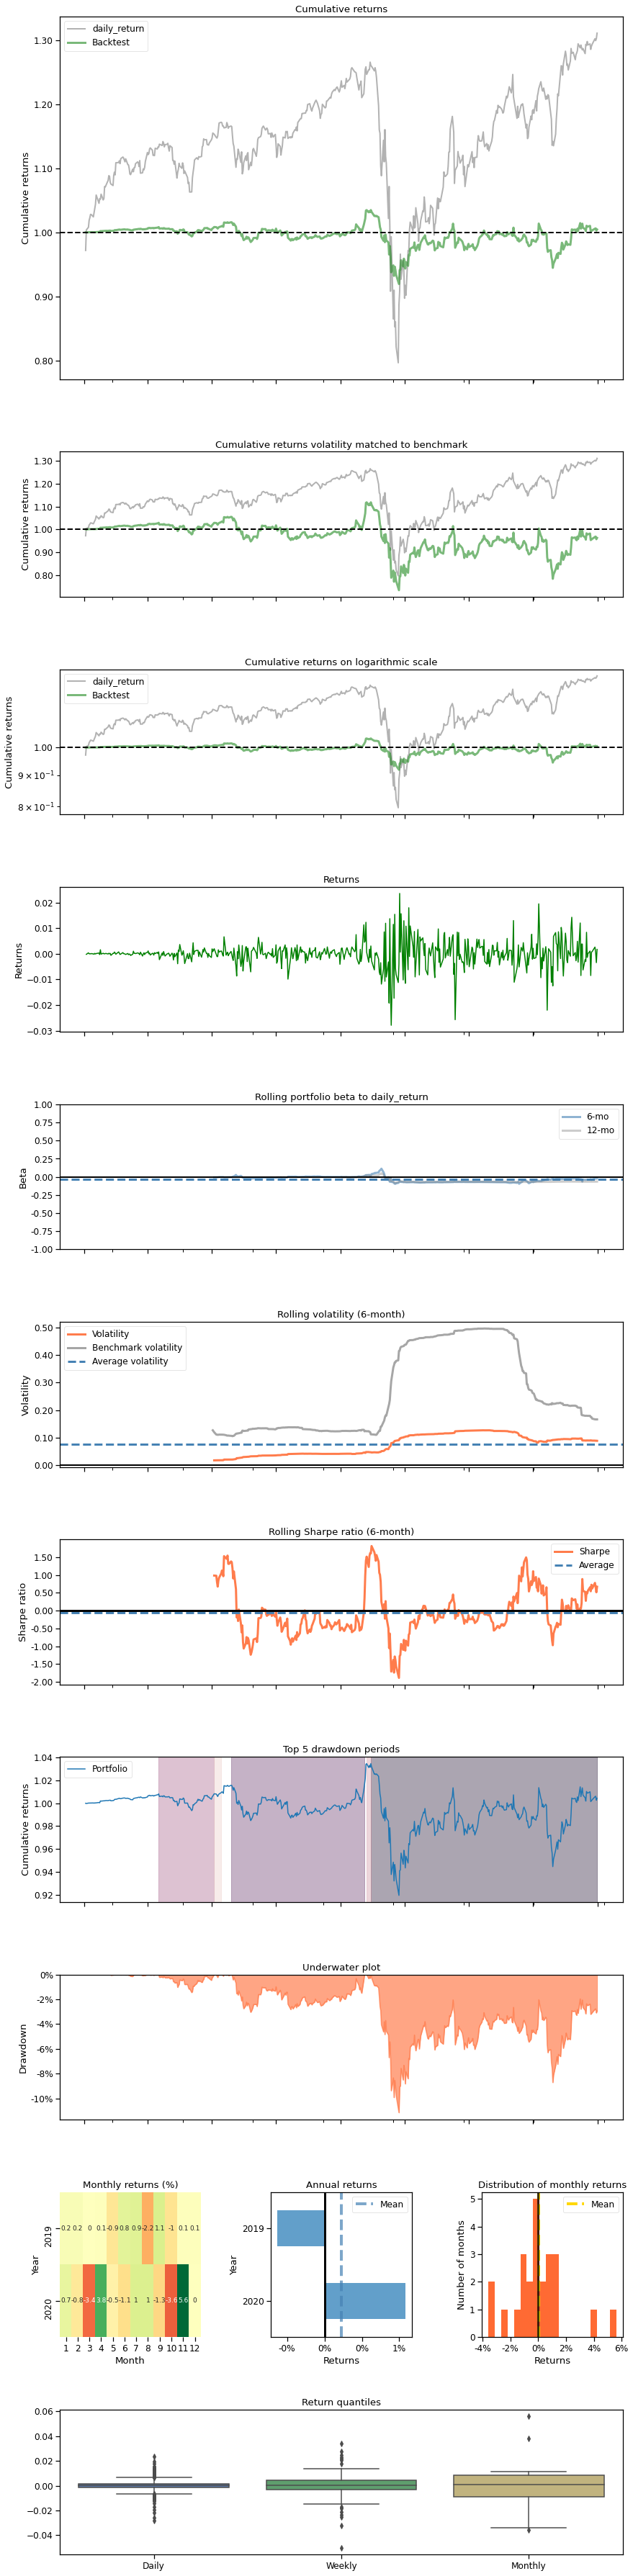

In [32]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')